# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Proyecto Integrador**

### Tecnológico de Monterrey

### Prof Dra. Grettel Barceló Alonso y Dr. Luis Eduardo Falcón Morales

## Avance V de Proyecto

## Modelo Final

## Integrantes del Equipo:
### - Erika Cardona Rojas            A01749170
### - Miriam Bönsch                  A01330346
### - Mardonio Manuel Román Ramírez  A01795265

In [1]:
import pandas as pd

# Importando modulos
import sys
from pathlib import Path

parent_folder = str(Path.cwd().parent)
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

import yaml

# Cargando Yaml
with open("../config.yaml", "r", encoding="utf-8") as file:
    config = yaml.safe_load(file)

from src import models as m

c:\Users\mardo\Documents\Repositories\Proyecto-Polifenoles\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#--------------------------------------------------
# Importando Datos Y Listas De Variables Relevantes
#--------------------------------------------------

# Cargando Base de Datos
df = pd.read_excel(r"../Data/DF_Pred_4.xlsx")

# Cargando las variables más importantes según RFECV 1
df_ranking = pd.read_excel('../Entregables/UdeBarcelona/RFECV.xlsx')
selected_features_xg = df_ranking.loc[df_ranking['Ranking'] == 1, 'Feature']

# Cargando las variables más importantes según RFECV 2
df_ranking = pd.read_excel('../Entregables/UdeBarcelona/RFECV_Lasso.xlsx')
selected_features_lasso = df_ranking.loc[df_ranking['Ranking'] == 1, 'Feature']

# Obteniendo variables únicas de ambos
unique_selected_features = list(set(pd.concat([selected_features_xg, selected_features_lasso])))

del df_ranking

In [3]:
# Creando conjuntos de datos
X_full = df[unique_selected_features]
y = df.loc[:,'delta_bdnf_Int']

> ### BUSQUEDA DEL MODELO UN MEJOR MODELO
> #### SEGUN VARIABLES IMPORTANTES DE RFECV CON LASSO

In [4]:
df_models_lasso, best_estimator_lasso = m.models_comparison_and_train_v2(X_full[selected_features_lasso], y, config['models_and_params_v2'])

16:02:30 - Iniciando Nested CV para: Ridge
16:02:34 - Ridge finalizado. Train R2: 0.986 | CV R2: 0.924 | Brecha R2: 0.062
16:02:34 - Iniciando Nested CV para: Lasso
16:02:34 - Lasso finalizado. Train R2: 0.986 | CV R2: 0.925 | Brecha R2: 0.062
16:02:34 - Iniciando Nested CV para: ElasticNet
16:02:36 - ElasticNet finalizado. Train R2: 0.986 | CV R2: 0.930 | Brecha R2: 0.056
16:02:36 - Iniciando Nested CV para: SVR
16:02:42 - SVR finalizado. Train R2: 0.982 | CV R2: 0.921 | Brecha R2: 0.061
16:02:42 - Iniciando Nested CV para: KNN Regressor
16:02:47 - KNN Regressor finalizado. Train R2: 1.000 | CV R2: 0.063 | Brecha R2: 0.937
16:02:47 - Iniciando Nested CV para: Decision Tree
16:02:49 - Decision Tree finalizado. Train R2: 0.153 | CV R2: -0.294 | Brecha R2: 0.447
16:02:49 - Iniciando Nested CV para: PLSRegression
16:02:50 - PLSRegression finalizado. Train R2: 0.986 | CV R2: 0.911 | Brecha R2: 0.075


In [5]:
# Guardando resultados para analisis posterior
df_models_lasso.to_excel('../Entregables/UdeBarcelona/models_Var_Lasso.xlsx', index = False)

> ### BUSQUEDA DEL MODELO UN MEJOR MODELO
> #### SEGUN VARIABLES IMPORTANTES DE RFECV CON XGBoost

In [6]:
df_models_XG, best_estimator_XG = m.models_comparison_and_train_v2(X_full[selected_features_xg], y, config['models_and_params_v2'])

16:02:50 - Iniciando Nested CV para: Ridge
16:02:52 - Ridge finalizado. Train R2: 0.108 | CV R2: -0.094 | Brecha R2: 0.202
16:02:52 - Iniciando Nested CV para: Lasso
16:02:53 - Lasso finalizado. Train R2: 0.000 | CV R2: -0.074 | Brecha R2: 0.074
16:02:53 - Iniciando Nested CV para: ElasticNet
16:02:56 - ElasticNet finalizado. Train R2: 0.194 | CV R2: -0.088 | Brecha R2: 0.282
16:02:56 - Iniciando Nested CV para: SVR
16:02:59 - SVR finalizado. Train R2: 1.000 | CV R2: 0.001 | Brecha R2: 0.999
16:02:59 - Iniciando Nested CV para: KNN Regressor
16:03:00 - KNN Regressor finalizado. Train R2: 0.111 | CV R2: -0.015 | Brecha R2: 0.125
16:03:00 - Iniciando Nested CV para: Decision Tree
16:03:02 - Decision Tree finalizado. Train R2: 0.171 | CV R2: -1.027 | Brecha R2: 1.198
16:03:02 - Iniciando Nested CV para: PLSRegression
16:03:03 - PLSRegression finalizado. Train R2: 0.419 | CV R2: -0.347 | Brecha R2: 0.766


In [7]:
# Guardando resultados para analisis posterior
df_models_XG.to_excel('../Entregables/UdeBarcelona/models_Var_XG.xlsx', index = False)

> ### BUSQUEDA DEL MODELO UN MEJOR MODELO
> #### SEGUN VARIABLES IMPORTANTES DE RFECV CON XGBoost

In [8]:
df_models_all, best_estimator_all = m.models_comparison_and_train_v2(X_full[unique_selected_features], y, config['models_and_params_v2'])

16:03:03 - Iniciando Nested CV para: Ridge
16:03:05 - Ridge finalizado. Train R2: 1.000 | CV R2: 0.289 | Brecha R2: 0.711
16:03:05 - Iniciando Nested CV para: Lasso
16:03:06 - Lasso finalizado. Train R2: 0.999 | CV R2: 0.233 | Brecha R2: 0.766
16:03:06 - Iniciando Nested CV para: ElasticNet
16:03:09 - ElasticNet finalizado. Train R2: 1.000 | CV R2: 0.303 | Brecha R2: 0.697
16:03:09 - Iniciando Nested CV para: SVR
16:03:11 - SVR finalizado. Train R2: 0.957 | CV R2: 0.555 | Brecha R2: 0.402
16:03:11 - Iniciando Nested CV para: KNN Regressor
16:03:13 - KNN Regressor finalizado. Train R2: 1.000 | CV R2: 0.050 | Brecha R2: 0.950
16:03:13 - Iniciando Nested CV para: Decision Tree
16:03:15 - Decision Tree finalizado. Train R2: 0.171 | CV R2: -1.101 | Brecha R2: 1.273
16:03:15 - Iniciando Nested CV para: PLSRegression
16:03:16 - PLSRegression finalizado. Train R2: 0.998 | CV R2: 0.228 | Brecha R2: 0.770


In [9]:
# Guardando resultados para analisis posterior
df_models_all.to_excel('../Entregables/UdeBarcelona/models_Var_all.xlsx', index = False)

> ## Segunda Prueba de Robustez

Tras evaluar los modelos mediante Validación Cruzada, se evidencia un contraste significativo en el rendimiento dependiendo de la estrategia de selección de características utilizada:

* **Descarte de selección por RFECV (XGBoost):** Los modelos entrenados con las variables seleccionadas mediante Eliminación Recursiva de Características (RFECV) con XGBoost, así como el conjunto masivo de variables catalogadas previamente como "importantes", muestran un desempeño deficiente. Estos presentan una brecha de $R^2$ sumamente amplia entre los conjuntos de entrenamiento y validación. En nuestro escenario analítico de alta dimensionalidad y tamaño muestral reducido, esta discrepancia es un indicador inequívoco de sobreajuste severo (overfitting); la complejidad de los métodos basados en árboles ha llevado a memorizar el ruido de la muestra en lugar de extraer patrones generalizables.
* **Aprobación de la selección por Lasso:** Por otro lado, se confirma la superioridad y robustez de los modelos entrenados con el subconjunto de características filtradas mediante regularización Lasso. Gracias a la penalización L1, Lasso efectúa una selección dispersa que mitiga eficientemente la multicolinealidad, reteniendo únicamente los predictores con verdadero impacto. Esto reduce la varianza y resulta en modelos consistentes con métricas de validación altamente competitivas.

**Siguiente Fase: Verificación de Robustez mediante Y-Randomization**
Para otorgar rigor estadístico absoluto a estos resultados y descartar la posibilidad de que el alto $R^2$ sea producto de correlaciones espurias (un riesgo constante al modelar múltiples variables en pocas observaciones), construiremos un experimento de *Y-Randomization* (Permutation Test) sobre los modelos ganadores. Al desordenar aleatoriamente la variable objetivo y reevaluar iterativamente, someteremos el modelo a una doble verificación para confirmar de manera concluyente que su capacidad predictiva se basa en una señal real en los datos y no en un artefacto matemático.

De esta manera, construiremos un conjunto de 4 modelos para hacer el ensamble, a continuación el criterio de decisión:
- El modelo es REAL (Luz verde para el ensamble): El p-value es $< 0.05$. En la gráfica, veremos la campana gris (el rendimiento con los datos de polifenoles desordenados) rondando cerca del cero o en valores negativos. La línea roja (el $R^2$ de 0.9) estará muy lejos a la derecha, totalmente separada de la campana de ruido.
- El modelo es un ARTEFACTO (Descartar): El p-value es $> 0.05$. La línea roja estará peligrosamente cerca o incluso dentro de la campana gris. Esto significaría que el modelo, por su flexibilidad geométrica, es capaz de sacar un $R^2$ alto incluso cuando predice datos de salud que no tienen ninguna relación con los indicadores.


In [10]:
# Creando Diccionario Con Los 4 Posibles Candidatos
models_dict = best_estimator_lasso
del best_estimator_lasso['KNN Regressor'], best_estimator_lasso['Decision Tree'], best_estimator_lasso['PLSRegression']

16:03:16 - Iniciando Y-Randomization para: Ridge (100 permutaciones)...
16:03:16 - Ridge -> R2 Real: 0.720 | R2 Ruido: -9.263 | p-value: 0.0099
16:03:16 - Iniciando Y-Randomization para: Lasso (100 permutaciones)...
16:03:16 - Lasso -> R2 Real: 0.671 | R2 Ruido: -14.737 | p-value: 0.0099
16:03:16 - Iniciando Y-Randomization para: ElasticNet (100 permutaciones)...
16:03:17 - ElasticNet -> R2 Real: 0.693 | R2 Ruido: -11.953 | p-value: 0.0099
16:03:17 - Iniciando Y-Randomization para: SVR (100 permutaciones)...
16:03:17 - SVR -> R2 Real: 0.648 | R2 Ruido: -5.224 | p-value: 0.0099


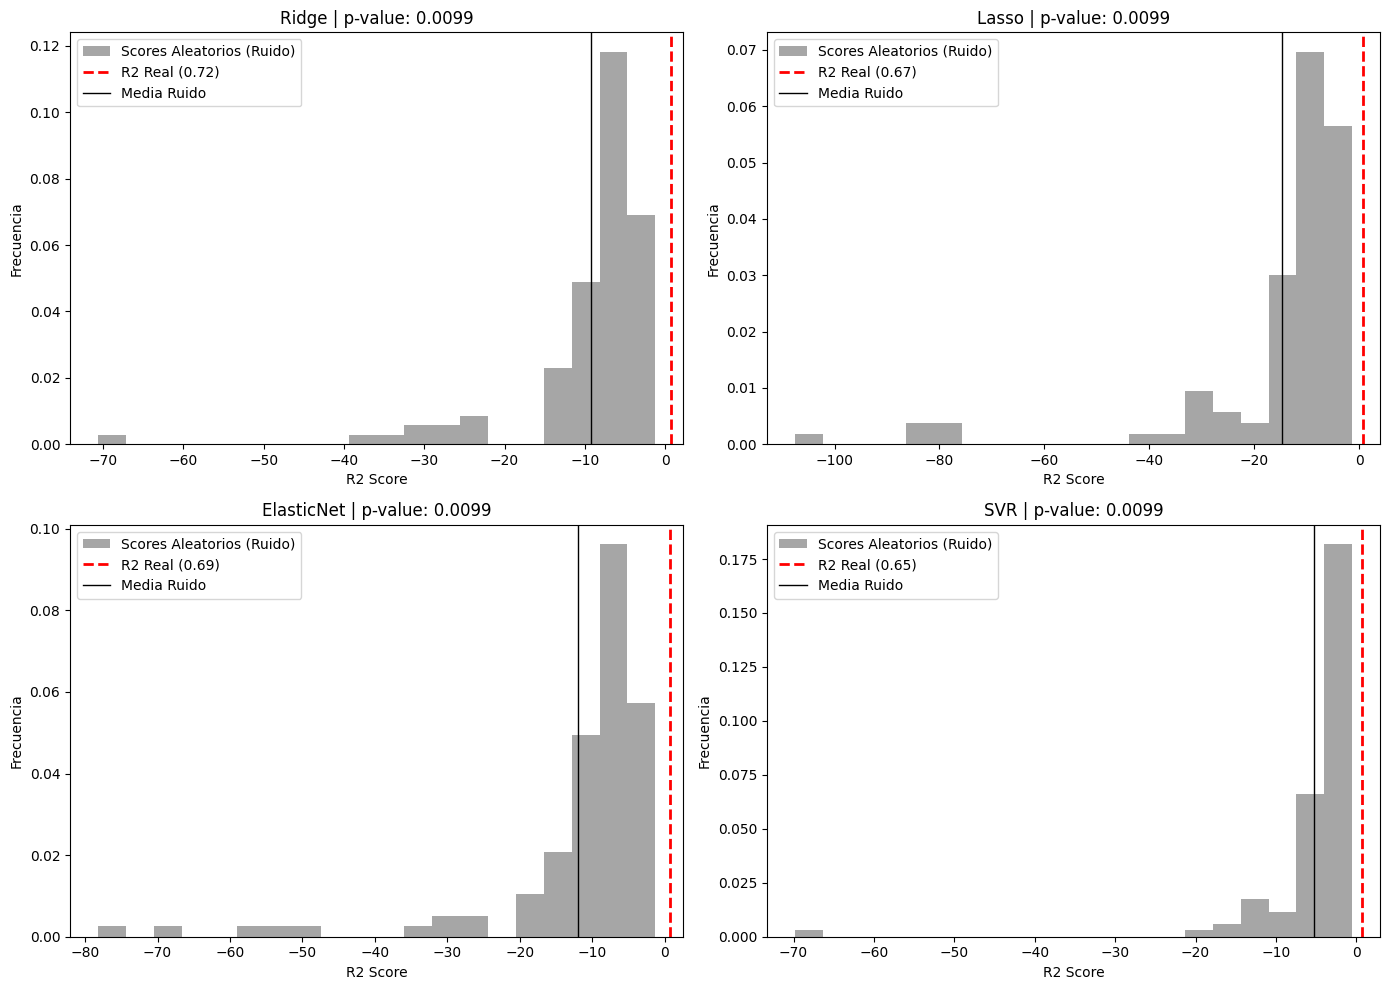

{'Ridge': {'R2 Real': np.float64(0.7202279083300824),
  'R2 Promedio Ruido': np.float64(-9.263065551445548),
  'p-value': np.float64(0.009900990099009901)},
 'Lasso': {'R2 Real': np.float64(0.6711254513637037),
  'R2 Promedio Ruido': np.float64(-14.73726453390957),
  'p-value': np.float64(0.009900990099009901)},
 'ElasticNet': {'R2 Real': np.float64(0.6931121320991807),
  'R2 Promedio Ruido': np.float64(-11.952993148426081),
  'p-value': np.float64(0.009900990099009901)},
 'SVR': {'R2 Real': np.float64(0.6475553874381985),
  'R2 Promedio Ruido': np.float64(-5.22447819956086),
  'p-value': np.float64(0.009900990099009901)}}

In [11]:
m.run_y_randomization_test(models_dict, X_full[selected_features_lasso], y)


### Validación Estadística de los Modelos: Y-Randomization (Permutation Test)

Para garantizar la robustez metodológica de nuestra investigación y descartar la posibilidad de sobreajuste debido a la alta dimensionalidad de los biomarcadores frente al tamaño muestral ($N=42$), los cuatro modelos seleccionados fueron sometidos a una prueba rigurosa de *Y-Randomization* (Permutation Test). 

Se realizaron 100 permutaciones utilizando una validación cruzada estricta de 8 particiones (8-Fold CV). El objetivo de esta prueba es destruir cualquier relación verdadera entre las variables predictoras y la respuesta cognitiva (variable objetivo) mediante la mezcla aleatoria de la variable $y$. 



Los resultados obtenidos son concluyentes y altamente favorables:

* **Ridge:** $R^2$ Real = 0.720 | $R^2$ Ruido = -9.26 | p-value < 0.01
* **ElasticNet:** $R^2$ Real = 0.693 | $R^2$ Ruido = -11.95 | p-value < 0.01
* **Lasso:** $R^2$ Real = 0.670 | $R^2$ Ruido = -14.73 | p-value < 0.01
* **SVR:** $R^2$ Real = 0.647 | $R^2$ Ruido = -5.22 | p-value < 0.01

#### Justificación de los Resultados:

1. **Significancia Estadística Absoluta ($p < 0.01$):** En los cuatro modelos, el valor p empírico alcanzó el límite inferior matemático posible para 100 iteraciones (0.0099). Esto demuestra que en ninguna de las permutaciones aleatorias el modelo fue capaz de alcanzar o superar el rendimiento original. La capacidad predictiva de los modelos se fundamenta en verdaderas señales biológicas y no en artefactos matemáticos generados por el azar.
2. **Rechazo del Ruido ($R^2$ Promedio Negativo):** Es de vital importancia observar los valores profundamente negativos en el "$R^2$ Promedio Ruido" (oscilando entre -5.22 y -14.73). Un $R^2$ negativo extremo indica que cuando los algoritmos intentan predecir datos sin sentido biológico, fallan drásticamente, rindiendo mucho peor que si simplemente predijeran la media. Esto confirma que los hiperparámetros optimizados son altamente específicos para la dinámica real de los polifenoles y no son lo suficientemente flexibles como para memorizar ruido blanco.
3. **Jerarquía de Rendimiento:** El modelo **Ridge** demostró el mejor poder predictivo (0.720), lo cual es coherente con su naturaleza matemática (penalización L2) diseñada para lidiar con multicolinealidad, una característica intrínseca de los estudios nutricionales donde múltiples biomarcadores se expresan en conjunto. Le siguen **ElasticNet** y **Lasso**, confirmando que la selección dispersa de variables es efectiva. Finalmente, **SVR** mantiene un nivel predictivo competitivo capturando relaciones no lineales residuales.

---

## Modelo De Ensamble


Hemos comprobado de manera concluyente y con rigor estadístico que nuestros 4 modelos base son altamente predictivos, estables y no están sobreajustados. Basándonos en esta evidencia, el siguiente paso lógico para maximizar la generalización es construir un modelo unificado. 

> Pasaremos a construir un modelo de **Voting Regressor** que promediará las predicciones de Ridge, Lasso, ElasticNet y SVR, capitalizando las fortalezas matemáticas individuales de cada uno para crear un sistema de evaluación final robusto e interpretable.

In [12]:
modelo_final = m.build_and_evaluate_ensemble(models_dict, X_full[selected_features_lasso], y)

16:03:17 - Construyendo el ensamble unificado...
16:03:17 - Evaluando el ensamble con LOOCV...



RESULTADOS DEL MODELO FINAL ENSAMBLADO
R2 Entrenamiento (Train):      0.9859
R2 Validación (LOOCV Test):    0.9287
Brecha de R2 (Train - Test):   0.0572
RMSE de Validación:            8.7566


In [13]:
modelo_final

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('ensamble', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingRegressor`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('Ridge', ...), ('Lasso', ...), ...]"
,"weights weights: array-like of shape (n_regressors,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted values before averaging. Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False


# Interpretación Del Modelo

16:03:17 - Calculando valores SHAP (KernelExplainer)... esto puede tomar un momento.
  0%|          | 0/42 [00:00<?, ?it/s]16:03:17 - num_full_subsets = 2
16:03:17 - remaining_weight_vector = array([0.21046803, 0.16837443, 0.14432094, 0.12951879, 0.12026745,
       0.11480075, 0.11224962])
16:03:17 - num_paired_subset_sizes = 9
16:03:17 - weight_left = np.float64(0.5381032434909889)
16:03:17 - np.sum(w_aug) = np.float64(19.0)
16:03:17 - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
16:03:17 - phi = array([  7.91383102,   0.        ,  -3.34243468, -17.26990252,
        -4.09280865,  -3.89541788,  -4.84558962,   0.        ,
         5.85945808,   5.0908419 ,   0.        ,   0.        ,
        -2.89874129,  -4.20213277,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ])
16:03:17 - num_full_subsets = 2
16:03:17 - remaining_weight_vector = array([0.21046803, 0.16837443, 0.14432094, 0.12951879, 0.12026745,
       0.11480075, 0.11224962])
16:03:17 - n

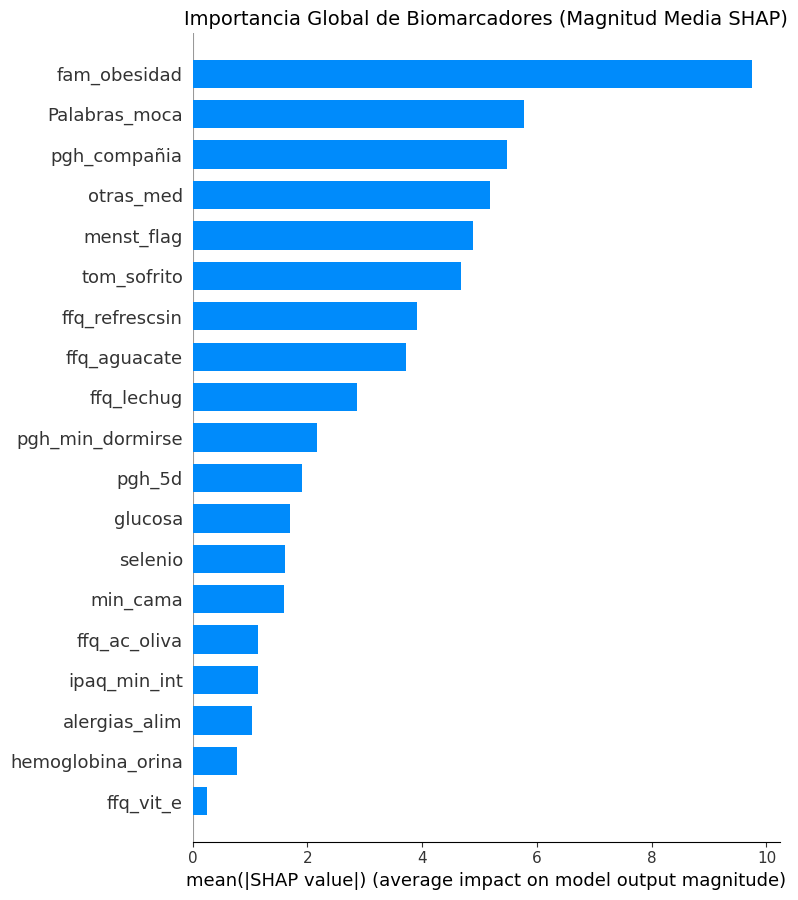

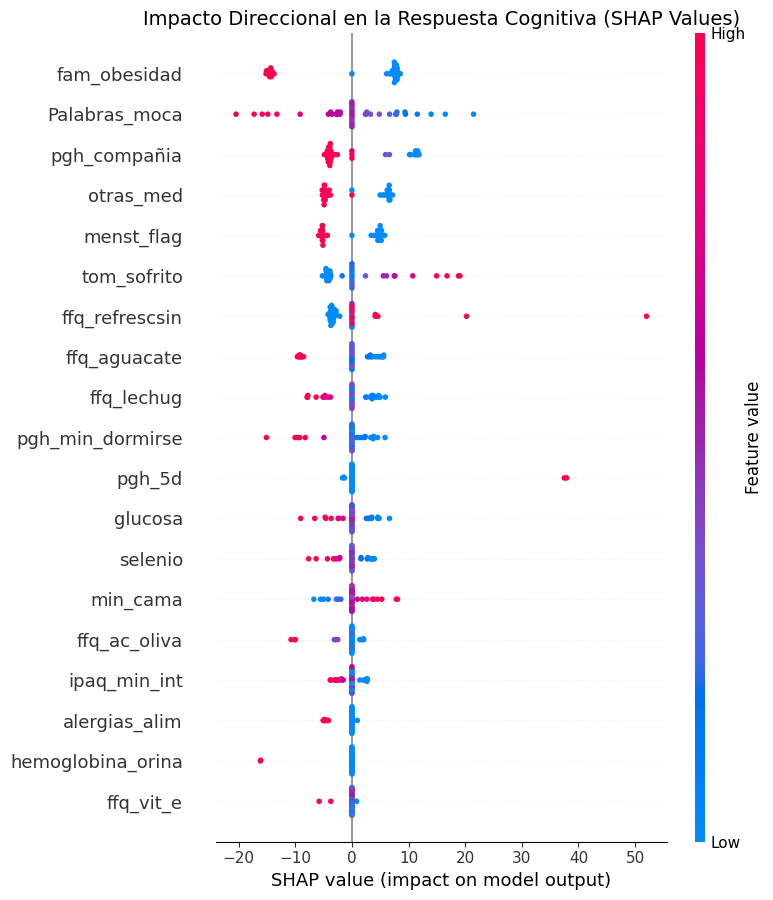


 INTERPRETACIÓN PARA EL REPORTE 
### Análisis de Importancia de Variables (SHAP)

El modelo de ensamble unificado fue sometido a una interpretación mediante Valores de Shapley (SHAP) para cuantificar el impacto individual de cada variable en la respuesta cognitiva. 
Al evaluar el pipeline completo, las interpretaciones conservan la escala original de las mediciones.

Las 15 variables con mayor poder predictivo en el modelo son:
1. **fam_obesidad**: Demuestra un impacto negativo en la variable objetivo. (Magnitud media de impacto predictivo: 9.7484). Esto sugiere que niveles más elevados de este biomarcador/variable tienden a disminuir el indicador cognitivo evaluado (delta bdnf).
2. **Palabras_moca**: Demuestra un impacto negativo en la variable objetivo. (Magnitud media de impacto predictivo: 5.7731). Esto sugiere que niveles más elevados de este biomarcador/variable tienden a disminuir el indicador cognitivo evaluado (delta bdnf).
3. **pgh_compañia**: Demuestra un impacto negativo e

In [14]:
# Generando interpretaciones y valores shapley
explainer, matriz_shap = m.interpretar_ensamble_shap(modelo_final, X_full[selected_features_lasso], selected_features_lasso, 15)